In [92]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("movies.csv", encoding='latin-1')
data.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.00,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.00,Stand by Me,R,1986-08-22,89,8.10,Wil Wheaton,299174,Stephen King,1986
1,6000000.00,Paramount Pictures,USA,John Hughes,Comedy,70136369.00,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.80,Matthew Broderick,264740,John Hughes,1986
2,15000000.00,Paramount Pictures,USA,Tony Scott,Action,179800601.00,Top Gun,PG,1986-05-16,110,6.90,Tom Cruise,236909,Jim Cash,1986
3,18500000.00,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.00,Aliens,R,1986-07-18,137,8.40,Sigourney Weaver,540152,James Cameron,1986
4,9000000.00,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.00,Flight of the Navigator,PG,1986-08-01,90,6.90,Joey Cramer,36636,Mark H. Baker,1986


In [93]:
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('^display.', silent=True)

In [94]:
#Data understanding
for column in data.columns:
    print(data[column].value_counts())

0.00            2182
20000000.00      207
30000000.00      191
25000000.00      177
15000000.00      170
                ... 
29000001.00        1
128000000.00       1
24500000.00        1
300000.00          1
5800000.00         1
Name: budget, Length: 351, dtype: int64
Universal Pictures                        302
Warner Bros.                              294
Paramount Pictures                        259
Twentieth Century Fox Film Corporation    205
New Line Cinema                           172
                                         ... 
Film Science                                1
Dave Bell Associates                        1
Northern                                    1
Number 9 Films                              1
Audax Films                                 1
Name: company, Length: 2179, dtype: int64
USA                               4872
UK                                 698
France                             283
Canada                             150
Germany                  

# Prepearing the dataset for processing

In [5]:
#Get the names of movies with no budget and format the string for a URL
noBudgetMovies = data[data["budget"]==0][["year","name"]]
noBudgetMovies["name"] = noBudgetMovies["name"].str.replace(" ","_")
noBudgetMovies.head()

,year,name
25,1986,Short_Circuit
26,1986,The_Name_of_the_Rose
27,1986,Iron_Eagle
32,1986,Betty_Blue
35,1986,The_Karate_Kid_Part_II


### Requesting the missing budget values from Wikipedia API

In [6]:
from bs4 import BeautifulSoup
import requests

def getPage(movieName):
    S = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"
    PARAMS = {
        "action": "parse",
        "page": movieName,
        "format": "json"
    }
    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()
    return DATA

#Getting the budget value
def getBudget(DATA):
    try:
        soup = BeautifulSoup("<html>"+str(DATA["parse"]["text"]["*"])+"</html>",features="html.parser")
    except:
        return "parseError"
    table = soup.find("table",class_="infobox vevent")

    try:
        thList = table.find_all("th")
        tdList = table.find_all("td")
    except:
        return "redirect"

    budgetIndex = -1
    i=0
    for row in thList:
        if "Budget" in str(row):
            budgetIndex = i
            break
        i += 1

    if budgetIndex == -1:
        return "noBudget"
    
    budget = tdList[budgetIndex].contents
    
    try:
        if len(budget)==1 or len(budget)==2 and "reference" in budget[1]["class"]:
            return tdList[budgetIndex].contents[0]
    except:
        pass
    return budget

In [7]:
#Sends GET requests to wikipedia API to get the missing budget values
#Takes a long time ~35min
dict = {}

for movieName in noBudgetMovies["name"]:
    pageData = getPage(movieName)
    budget = getBudget(pageData)
    
    if budget=="redirect":
        name = movieName+"_(film)"
        pageData = getPage(name)
        budget = getBudget(pageData)
        if budget=="redirect":
            year = noBudgetMovies[noBudgetMovies["name"]==movieName]["year"].values[0]
            name = movieName+"_("+str(year)+"_film)"
            pageData = getPage(name)
            budget = getBudget(pageData)
            if budget=="redirect":
                dict[movieName] = "redirect. last tried name: "+name
                continue
    if budget=="noBudget":
        dict[movieName] = "noBudget"
        continue
    if budget=="parseError":
        dict[movieName] = "parseError"
        continue
    dict[movieName] = budget

KeyboardInterrupt: 

In [ ]:
#DO NOT RUN AGAIN IF YOU ALREADY HAVE RESULTS IN A FILE OR MAKE A BACKUP FIRST, BECAUSE API REQUESTS TAKE A LONG TIME TO GET!!!
#Writing dict to file for further processing. 
with open("wikiResults.txt","w",encoding="utf-8") as file:
    for key, value in dict.items():
        file.write(key+"==="+str(value).replace("\n"," ")+"\n")

### Take the budget values and parse them into floats

In [7]:
#Read the results from the file onto a new dictionary
dictFile = {}
with open("wikiResults.txt","r",encoding="utf-8") as file:
    lines = file.readlines()
for line in lines:
    if line=="":
        continue
    split = line.split("===")
    dictFile[split[0]] = split[1].replace("\n","")

In [8]:
def findNumericDigits(string):
    index = 0
    i =0
    for char in string:
        if char.isnumeric():
            index = i
            break
        i += 1
    return index

def parseBudgetValue(budget):
    currencies = {
        "£": 1.33,
        "€": 1.11,
        "AU$": 0.688
    }
    
    try:
        if "sup" in budget:
            return budget
        if "million" in budget or "Million" in budget:
            row = budget.split(" ")
            firstNr = findNumericDigits(row[0])
            value = budget[:firstNr]+str(float(row[0][firstNr:])*1000000)
        elif ","in budget:
            value = budget.replace(",","")
        else:
            value = budget

        if value[0] == "$":
            return float(value[1:])
        elif value[:3] == "US$":
            return float(value[3:])
        elif value[0] == "£":
            return float(value[1:])*currencies["£"]
        elif value[0] == "€":
            return float(value[1:])*currencies["€"]
        elif value[:3] == "AU$":
            return float(value[3:])*currencies["AU$"]
        elif value[:2] == "A$":
            return float(value[2:])*currencies["AU$"]
        else:
            return budget
    except:
        return budget

In [9]:
#Parse the value into a float
for key, value in dictFile.items():
    dictFile[key] = parseBudgetValue(value)

In [12]:
#Manual fixing of remaining errors
errors = ["noBudget","parseError","redirect"]
moviesWithErrors = []
for key, value in dictFile.items():
    if type(value)!= float and value not in errors:
        moviesWithErrors.append(key)
        print(key,value)
        budget = input("Enter new budget value: ")
        if budget == "":
            continue
        dictFile[key] = budget

Summer redirect. last tried name: Summer_(1986_film)
Enter new budget value: 
Link Unknown
Enter new budget value: 
Kangaroo redirect. last tried name: Kangaroo_(1986_film)
Enter new budget value: 
Wings_of_Desire ['5 million ', <a href="/wiki/Deutsche_Mark" title="Deutsche Mark">DM</a>, <sup class="reference" id="cite_ref-FOOTNOTELüdiLüdi200060_3-0"><a href="#cite_note-FOOTNOTELüdiLüdi200060-3">[3]</a></sup>]
Enter new budget value: 5 million Deutsche_Mark
Who's_That_Girl $17–20 million ($37.49 million in 2018)
Enter new budget value: $18.5 million
Wanted:_Dead_or_Alive $4,500,000 (US)
Enter new budget value: $4,500,000
Wisdom ['$6.5 million', <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup>, <sup class="reference" id="cite_ref-globe_3-0"><a href="#cite_note-globe-3">[3]</a></sup>]
Enter new budget value: $6.5 million
The_Allnighter approx $1 million
Enter new budget value: $1 million
The_Bedroom_Window ['$8.3 million', <sup class="reference" id="cite_ref-cu

In [20]:
#DO NOT RUN AGAIN. THIS WRITES THE MANUALLY INSERTED VALUES INTO A FILE
#Backup the dictFile with the new manually inserted values
with open("manuallyInserted.txt","w",encoding="utf-8") as file:
    for key, value in dictFile.items():
        file.write(key+"==="+str(value).replace("\n"," ")+"\n")

In [10]:
#Run after fresh start to get the manually fixed budget values
with open("manuallyInserted.txt","r",encoding="utf-8") as file:
    lines = file.readlines()
for line in lines:
    if line=="":
        continue
    split = line.split("===")
    dictFile[split[0]] = split[1].replace("\n","")

### Add the newfound values into the set

In [14]:
for key, value in dictFile.items():
    if type(value)==float:
        data[data["name"] == key.replace("_"," ")] = data[data["name"] == key.replace("_"," ")].replace(to_replace=0.0,value=value)

### Encoding labels

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

##strings to numbers
labelEncoder = LabelEncoder()
labelEncoder.fit(data['company'])
data['company'] = labelEncoder.transform(data['company'])

labelEncoder.fit(data['country'])
data['country'] = labelEncoder.transform(data['country'])

labelEncoder.fit(data['director'])
data['director'] = labelEncoder.transform(data['director'])

labelEncoder.fit(data['genre'])
data['genre'] = labelEncoder.transform(data['genre'])

labelEncoder.fit(data['name'])
data['name'] = labelEncoder.transform(data['name'])

labelEncoder.fit(data['rating'])
data['rating'] = labelEncoder.transform(data['rating'])

labelEncoder.fit(data['star'])
data['star'] = labelEncoder.transform(data['star'])

labelEncoder.fit(data['writer'])
data['writer'] = labelEncoder.transform(data['writer'])

labelEncoder.fit(data['released'])
data['released'] = labelEncoder.transform(data['released'])


data.head(20)

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.00,665,54,2192,1,52287414.00,4661,8,39,89,8.10,2454,299174,3716,1986
1,6000000.00,1680,54,1296,4,70136369.00,1821,7,27,103,7.80,1605,264740,1970,1986
2,15000000.00,1680,54,2645,0,179800601.00,6203,6,23,110,6.90,2345,236909,1852,1986
3,18500000.00,2062,54,1066,0,85160248.00,295,8,33,137,8.40,2192,540152,1629,1986
4,9000000.00,2122,54,2123,1,18564613.00,1872,6,36,90,6.90,1139,36636,2549,1986
5,6000000.00,1158,53,1948,6,138530565.00,3903,8,75,120,8.10,369,317585,2988,1986
6,25000000.00,1160,53,1207,1,12729917.00,2883,6,30,101,7.40,528,102879,977,1986
7,6000000.00,768,54,588,6,8551228.00,771,8,51,120,7.80,924,146768,897,1986
8,9000000.00,1680,54,1004,4,40471663.00,3964,7,9,96,6.80,1730,60565,1970,1986
9,15000000.00,1854,54,557,6,40456565.00,5306,8,38,96,7.50,1039,129698,1333,1986


### Drop all movies with no budget

In [96]:
data = data[data["budget"]!=0]

# Working with the data

In [97]:
labels = data["gross"]
movie_data = data.drop(["gross"],1)

X_train, X_test, y_train, y_test = train_test_split(movie_data, labels, test_size = 0.3, random_state = 0)

In [98]:
rf = RandomForestClassifier(criterion="gini",n_estimators=80, max_depth=160).fit(X_train, y_train)
predictions = rf.predict(X_test)
pList = predictions.tolist()

In [99]:
accuracyResults = pd.DataFrame(columns=["name","realGross","predictedGross","difference"])
for i in range(len(pList)):
    row = X_test.iloc[i]
    label = y_test.iloc[i]
    accuracyResults = accuracyResults.append({"name":row["name"],"realGross":label,"predictedGross":pList[i],"difference":abs(label-pList[i])},ignore_index=True)

with open("modelsUsed.txt","a",encoding="utf-8") as f:
    f.write("model==="+str(rf)+"\tmean==="+str(accuracyResults["difference"].mean())+"\n")
accuracyResults["difference"].describe()

count        1392.00
mean     32877095.95
std      50082183.13
min            14.00
25%       4839755.00
50%      16704726.00
75%      42138395.75
max     748642208.00
Name: difference, dtype: float64

In [100]:
testDf = X_train.copy()
testDf.head()
#testDf.add(["test"])

,budget,company,country,director,genre,name,rating,released,runtime,score,star,votes,writer,year
2687,60000000.00,2123,53,2011,0,4567,8,968,99,6.00,1402,46241,941,1998
1004,225000.00,2135,54,2694,4,3306,7,349,98,7.50,336,7776,4102,1990
4562,12000000.00,1721,54,2298,4,4254,8,1576,122,6.20,1209,20590,3518,2006
3845,11000000.00,1818,54,1372,9,1306,7,1294,86,5.00,359,27228,1894,2003
4963,8000000.00,1802,54,1714,9,4467,7,1672,85,5.20,1226,28640,2463,2008


In [101]:
#predictedDF["gross"] = predictions

In [102]:
accuracyResults.head()

,name,realGross,predictedGross,difference
0,118.00,7458269.00,17266971.00,9808702.00
1,2398.00,31155435.00,12784713.00,18370722.00
2,3597.00,31487293.00,17536788.00,13950505.00
3,3944.00,23000.00,389804.00,366804.00
4,4608.00,52008288.00,25812.00,51982476.00


In [103]:
accuracyResults.apply (pd.to_numeric, errors='coerce')
accuracyResults = accuracyResults.dropna()
accuracyResults

,name,realGross,predictedGross,difference
0,118.00,7458269.00,17266971.00,9808702.00
1,2398.00,31155435.00,12784713.00,18370722.00
2,3597.00,31487293.00,17536788.00,13950505.00
3,3944.00,23000.00,389804.00,366804.00
4,4608.00,52008288.00,25812.00,51982476.00
...,...,...,...,...
1387,1037.00,1731665.00,3049135.00,1317470.00
1388,6477.00,22466994.00,580862.00,21886132.00
1389,984.00,18671317.00,60864870.00,42193553.00
1390,1477.00,41909762.00,35739802.00,6169960.00


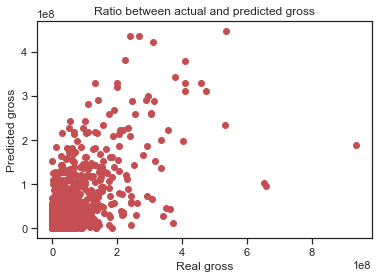

In [132]:
plt.scatter(accuracyResults["realGross"],accuracyResults["predictedGross"],color="r")
plt.xlabel("Real gross")
plt.ylabel("Predicted gross")
plt.title("Ratio between actual and predicted gross")

In [116]:
from scipy import stats

#the biggest correlations between gross and a feature
#budget
pearson_coef, p_value = stats.pearsonr(data["budget"], data["gross"])
print("Pearson Correlation Coefficient: ", pearson_coef)

Pearson Correlation Coefficient:  0.7121955325421071


In [117]:
#votes
pearson_coef, p_value = stats.pearsonr(data["votes"], data["gross"])
print("Pearson Correlation Coefficient: ", pearson_coef)

Pearson Correlation Coefficient:  0.6624571618429045


In [ ]:
#correlation between gross and other features
import seaborn as sns
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data = data, x_vars = ["budget","company","country","director","genre","name"], y_vars = ["gross"])
g = sns.pairplot(data = data, x_vars = ["rating","released","runtime","score","star","votes"], y_vars = ["gross"])
g = sns.pairplot(data = data, x_vars = ["writer","year"], y_vars = ["gross"])

In [120]:
sort = data.sort_values(by = ["gross"], ascending=[False])

In [134]:
#finding the 100 movies with biggest gross
biggest_values = sort.head(100)
biggest_values.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
6380,245000000.00,Lucasfilm,USA,J.J. Abrams,Action,936662225.00,Star Wars: The Force Awakens,PG-13,2015-12-18,136,8.10,Daisy Ridley,687192,Lawrence Kasdan,2015
5061,237000000.00,Twentieth Century Fox Film Corporation,UK,James Cameron,Action,760507625.00,Avatar,PG-13,2009-12-18,162,7.80,Sam Worthington,954412,James Cameron,2009
2420,200000000.00,Twentieth Century Fox Film Corporation,USA,James Cameron,Drama,658672302.00,Titanic,PG-13,1997-12-19,194,7.80,Leonardo DiCaprio,862554,James Cameron,1997
6391,150000000.00,Universal Pictures,USA,Colin Trevorrow,Action,652270625.00,Jurassic World,PG-13,2015-06-12,124,7.00,Chris Pratt,469200,Rick Jaffa,2015
5723,220000000.00,Marvel Studios,USA,Joss Whedon,Action,623357910.00,The Avengers,PG-13,2012-05-04,143,8.10,Robert Downey Jr.,1064633,Joss Whedon,2012


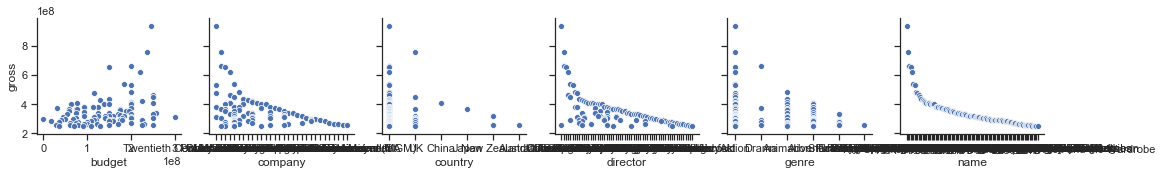

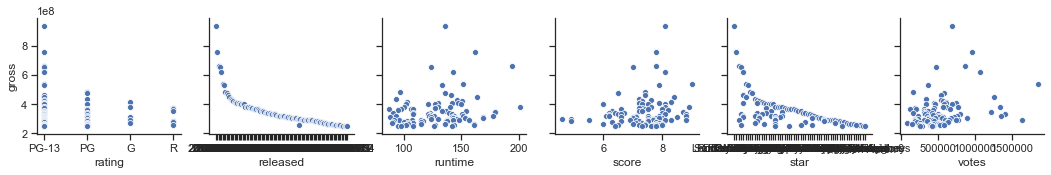

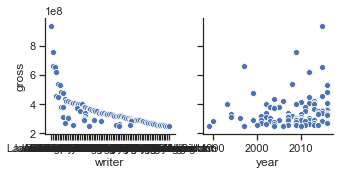

In [122]:
g = sns.pairplot(data = biggest_values, x_vars = ["budget","company","country","director","genre","name"], y_vars = ["gross"])
g = sns.pairplot(data = biggest_values, x_vars = ["rating","released","runtime","score","star","votes"], y_vars = ["gross"])
g = sns.pairplot(data = biggest_values, x_vars = ["writer","year"], y_vars = ["gross"])

In [135]:
#finding data, where gross is at least twice the budget

best_data = pd.DataFrame(data, columns = ["budget","company","country","director","genre","gross","name","rating","released",
                                          "runtime","score","star","votes","writer","year"])

# for i in range(len(best_data)):
#     if best_data.iloc[i,:].budget == 0.0 or best_data.iloc[i,:].budget == 0:
#         best_data.drop(best_data.index[i])
        
for i in range(len(best_data)):
    if best_data.iloc[i,:].gross/best_data.iloc[i,:].budget < 2:
        best_data.drop(best_data.index[i])
        
best_data.head()

C:\Users\karen99\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.00,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.00,Stand by Me,R,1986-08-22,89,8.10,Wil Wheaton,299174,Stephen King,1986
1,6000000.00,Paramount Pictures,USA,John Hughes,Comedy,70136369.00,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.80,Matthew Broderick,264740,John Hughes,1986
2,15000000.00,Paramount Pictures,USA,Tony Scott,Action,179800601.00,Top Gun,PG,1986-05-16,110,6.90,Tom Cruise,236909,Jim Cash,1986
3,18500000.00,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.00,Aliens,R,1986-07-18,137,8.40,Sigourney Weaver,540152,James Cameron,1986
4,9000000.00,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.00,Flight of the Navigator,PG,1986-08-01,90,6.90,Joey Cramer,36636,Mark H. Baker,1986


In [ ]:
data = pd.read_csv("movies.csv", encoding='latin-1')

best_data = pd.DataFrame(data, columns = ["budget","company","country","director","genre","gross","name","rating","released",
                                          "runtime","score","star","votes","writer","year"])

for i in range(len(best_data)):
    if best_data.iloc[i,:].gross/best_data.iloc[i,:].budget < 2:
        best_data.drop(best_data.index[i])

In [ ]:
g = sns.pairplot(data = best_data, x_vars = ["budget","company","country","director","genre","name"], y_vars = ["gross"])
g = sns.pairplot(data = best_data, x_vars = ["rating","released","runtime","score","star","votes"], y_vars = ["gross"])
g = sns.pairplot(data = best_data, x_vars = ["writer","year"], y_vars = ["gross"])